### Installing basic dependencies

In [1]:
!pip install Pillow

     ---------------------------------------- 2.5/2.5 MB 1.3 MB/s eta 0:00:00


In [5]:
!pip install opencv-python

     ---------------------------------------- 38.2/38.2 MB 9.0 MB/s eta 0:00:00


In [7]:
!pip install matplotlib

     ---------------------------------------- 7.6/7.6 MB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 160.2/160.2 kB ? eta 0:00:00
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     -------------------------------------- 55.4/55.4 kB 144.3 kB/s eta 0:00:00
     ---------------------------------------- 1.0/1.0 MB 908.6 kB/s eta 0:00:00


In [9]:
!pip install seaborn

     ------------------------------------ 293.3/293.3 kB 270.3 kB/s eta 0:00:00


In [11]:
!pip install scipy

     ---------------------------------------- 42.5/42.5 MB 8.4 MB/s eta 0:00:00


In [ ]:

!pip --quiet install onnx onnxruntime onnxsim
!pip install onnx-tf

### Cloning the Official YOLO V7 repository and downloading the official model

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git


In [2]:
%cd yolov7

D:\gans\git_upload\ML-in-production\5_deployment\tf_lite\yolov7_to_tflite\yolov7


### Converting the ONNX model

In [12]:

!python export.py --weights yolov7.pt --grid --end2end --simplify \
--topk-all 100 --iou-thres 0.65 --conf-thres 0.35 --img-size 640 640 --max-wh 640

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(weights='yolov7.pt', img_size=[640, 640], batch_size=1, dynamic=False, dynamic_batch=False, grid=True, end2end=True, max_wh=640, topk_all=100, iou_thres=0.65, conf_thres=0.35, device='cpu', simplify=True, include_nms=False, fp16=False, int8=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block

Starting TorchScript export with torch 1.12.1+cu113...
TorchScript export success, saved as yolov7.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.12.1+cu113...
TorchScript-Lite export success, saved as yolov7.torchscript.ptl

Starting ONNX export with onnx 1.13.1...
onnxruntime

Starting to simplify ONNX...
ONNX export success, saved as yolov7.onnx

Export complete (28.07s). Visualize with https://github.com/lutzroeder/netron.


YOLOR  v0.1-122-g3b41c2c torch 1.12.1+cu113 CPU

Model Summary: 306 layers, 36905341 parameters, 36905341 gradients
C:\Users\tharh\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
D:\gans\git_upload\ML-in-production\5_deployment\tf_lite\yolov7_to_tflite\yolov7\models\yolo.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.grid[i].shape[2:4] != x[i].shape[2:4]:
C:\Users\tharh\AppData\Roaming\Python\Python39\site-packages\torch\_tensor.

grid: The grid parameter is an option allowing the export of the detection layer grid.

end2end: It is the option that allows the export of end-to-end ONNX graph which does both bounding box prediction and NMS.

simplify: It is the option by which we can select whether we want to simplify the ONNX graph using reparameterization.

topk-all: It's the option to select the top k object per image using IOU and confidence threshold.

iou-thres: It is the option to set the IOU threshold for NMS.

conf-thres: It is the option to select the confidence threshold score.

img_size and max-wh: These parameters are related to the size of the input image.

(636, 574, 3)


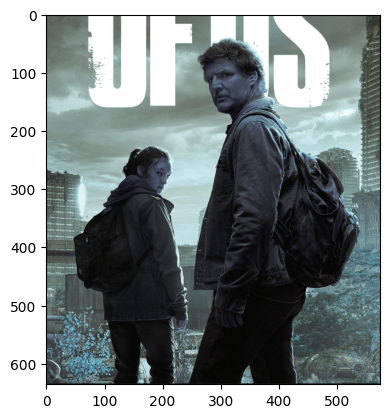

In [25]:
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import matplotlib.pyplot as plt
import cv2
import random
cuda = False
w = "yolov7.onnx"
#Loading image for testing.
img = cv2.imread('test_images/Screenshot_2.png')
print(img.shape)
plt.imshow(img)

### Defining ONNX inference session, helper function, and some other information

In [26]:
#Loading the ONNX inference session.
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] if cuda else ['CPUExecutionProvider']
session = ort.InferenceSession(w, providers=providers)
print("providers : ",providers)

providers :  ['CPUExecutionProvider']


In [27]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)


In [28]:
#Name of the classes according to class indices.
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']

#Creating random colors for bounding box visualization.
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}


#### Making predictions with onnx model and visualizing results

Inference time :  0.31674861907958984


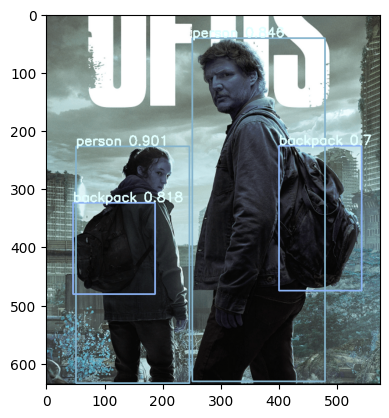

In [30]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Preprocessing the image for prediction.
image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
im.shape

#Getting onnx graph input and output names.
outname = [i.name for i in session.get_outputs()]
inname = [i.name for i in session.get_inputs()]
inp = {inname[0]:im}

import time
start_time = time.time()
# Running inference using session.
outputs = session.run(outname, inp)[0]
print("Inference time : ", time.time() - start_time)

ori_images = [img.copy()]

#Visualizing bounding box prediction.
for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

plt.imshow(ori_images[0])

### Converting the Onnx Model to Tensorflow

In [32]:
!pip install tensorflow_probability

     ---------------------------------------- 6.7/6.7 MB 3.0 MB/s eta 0:00:00
     -------------------------------------- 101.5/101.5 kB 6.1 MB/s eta 0:00:00


In [35]:
!onnx-tf convert -i yolov7.onnx -o tf_model/

2023-03-07 15:08:36,750 - onnx-tf - INFO - Start converting onnx pb to tf saved model
2023-03-07 15:08:36.903969: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
2023-03-07 15:08:52,479 - onnx-tf - INFO - Converting completes successfully.
INFO:onnx-tf:Converting completes successfully.


### Converting the TensorFlow model to tflite

In [37]:
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model('tf_model/')
tflite_model = converter.convert()

with open('tflite_model/yolov7_model.tflite', 'wb') as f:
  f.write(tflite_model)

### Making predictions using the TFlite model

In [38]:
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="tflite_model/yolov7_model.tflite")



In [39]:
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

#Name of the classes according to class indices.
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']

#Creating random colors for bounding box visualization.
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}


In [40]:
img = cv2.imread('test_images/Screenshot_2.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255


In [42]:
#Allocate tensors.
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("input_details : ",input_details)
print()
print("output_details : ",output_details)


input_details :  [{'name': 'serving_default_images:0', 'index': 0, 'shape': array([  1,   3, 640, 640]), 'shape_signature': array([  1,   3, 640, 640]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]

output_details :  [{'name': 'StatefulPartitionedCall:0', 'index': 821, 'shape': array([1, 7]), 'shape_signature': array([-1,  7]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [43]:
# Test the model on random input data.
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], im)


In [44]:
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])


In [45]:
print("output_data : ",output_data)

output_data :  [[ 0.0000000e+00  8.1823654e+01  2.2807208e+02  2.7902094e+02
   6.3814807e+02  0.0000000e+00  9.0925395e-01]
 [ 0.0000000e+00  2.8385208e+02  4.0186310e+01  4.9934140e+02
   6.3480701e+02  0.0000000e+00  8.8278514e-01]
 [ 0.0000000e+00  7.7667755e+01  3.2503934e+02  2.1830011e+02
   4.8454355e+02  2.4000000e+01  8.4217829e-01]
 [ 0.0000000e+00  4.2805954e+02  2.2460910e+02  5.7727258e+02
   4.7760641e+02  2.4000000e+01  6.5791559e-01]
 [ 0.0000000e+00 -5.3953457e-01 -5.2655363e-01  8.7261477e+00
   9.6936722e+00  0.0000000e+00  3.4970666e-09]
 [ 0.0000000e+00 -5.3953457e-01 -5.2655363e-01  8.7261477e+00
   9.6936722e+00  0.0000000e+00  3.4970666e-09]
 [ 0.0000000e+00 -5.3953457e-01 -5.2655363e-01  8.7261477e+00
   9.6936722e+00  0.0000000e+00  3.4970666e-09]
 [ 0.0000000e+00 -5.3953457e-01 -5.2655363e-01  8.7261477e+00
   9.6936722e+00  0.0000000e+00  3.4970666e-09]
 [ 0.0000000e+00 -5.3953457e-01 -5.2655363e-01  8.7261477e+00
   9.6936722e+00  0.0000000e+00  3.4970666e

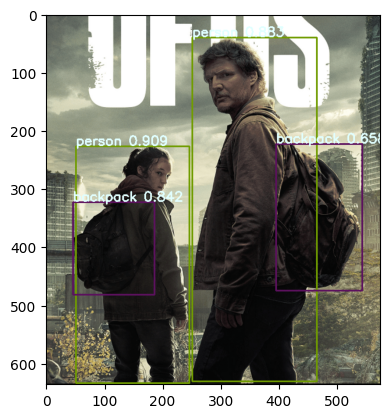

In [46]:

ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(output_data):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1])
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id)
    score = round(float(score),3)
    name = names[cls_id]
    color = colors[name]
    name += ' '+str(score)
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  
plt.imshow(ori_images[0])